# HDB Resale Price Prediction

## Machine Learning Modelling

### Import Libraries

In [10]:
# General
import math
import random
random.seed(42)
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import randint
from scipy.stats import uniform

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn import tree

# Pre-Processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler      # Remove Mean and scale to Unit Variance
from sklearn.preprocessing import PowerTransformer    # Log Transformation
from sklearn.preprocessing import OneHotEncoder

# Feature Engineering
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

# Evaluation Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
import catboost as cb

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Warnings
import warnings
warnings.filterwarnings('ignore')

### Import Dataset

In [11]:
# Importing Data
data_hdb_cleaned = pd.read_csv('../dataset/hdb_last15_cleaned.csv')
data_hdb_cleaned.index += 1
data_hdb_cleaned

,town,flat_type,flat_model,floor_area_sqm,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,...,recreational_within_1km_average_rating,recreational_within_2km_count,recreational_within_2km_average_rating,education_within_1km_count,education_within_1km_average_rating,education_within_2km_count,education_within_2km_average_rating,postal_code,region,price_per_sqm
1,SEMBAWANG,5 ROOM,Premium Apartment,111.0,362000.0,2009-07-01,2001,01 TO 05,357A,91.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,3261.261261
2,SEMBAWANG,5 ROOM,Premium Apartment,110.0,370000.0,2009-08-01,2001,06 TO 10,357A,91.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,3363.636364
3,SEMBAWANG,5 ROOM,Premium Apartment,110.0,403000.0,2010-01-01,2001,16 TO 20,357A,90.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,3663.636364
4,SEMBAWANG,4 ROOM,Premium Apartment,95.0,350000.0,2010-07-01,2001,01 TO 05,357A,90.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,3684.210526
5,SEMBAWANG,4 ROOM,Premium Apartment,95.0,399000.0,2010-07-01,2001,10 TO 15,357A,90.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,4200.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316854,BUKIT MERAH,5 ROOM,Improved,114.0,921000.0,2022-10-01,1974,10 TO 15,87,50.750000,...,4.057143,78.0,4.052564,3.0,2.700,25.0,3.348,160087.0,South,8078.947368
316855,BUKIT MERAH,5 ROOM,Improved,117.0,930000.0,2022-10-01,1974,01 TO 05,87,50.750000,...,4.057143,78.0,4.052564,3.0,2.700,25.0,3.348,160087.0,South,7948.717949
316856,BUKIT MERAH,5 ROOM,Improved,117.0,978000.0,2022-12-01,1974,10 TO 15,87,50.666667,...,4.057143,78.0,4.052564,3.0,2.700,25.0,3.348,160087.0,South,8358.974359
316857,BUKIT MERAH,5 ROOM,Improved,114.0,950000.0,2022-12-01,1974,21 TO 25,87,50.583333,...,4.057143,78.0,4.052564,3.0,2.700,25.0,3.348,160087.0,South,8333.333333


In [12]:
# Understanding Data I
data_hdb_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316858 entries, 1 to 316858
Data columns (total 35 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   town                                    316858 non-null  object 
 1   flat_type                               316858 non-null  object 
 2   flat_model                              316858 non-null  object 
 3   floor_area_sqm                          316858 non-null  float64
 4   resale_price                            316858 non-null  float64
 5   month                                   316858 non-null  object 
 6   lease_commence_date                     316858 non-null  int64  
 7   storey_range                            316858 non-null  object 
 8   block                                   316858 non-null  object 
 9   remaining_lease                         316858 non-null  float64
 10  address                                 3168

In [13]:
# Understanding Data II
data_hdb_cleaned.describe()

,floor_area_sqm,resale_price,lease_commence_date,remaining_lease,lat,long,nearest_distance_to_mrt,avg_long,avg_lat,healthcare_within_1km_count,...,recreational_within_1km_count,recreational_within_1km_average_rating,recreational_within_2km_count,recreational_within_2km_average_rating,education_within_1km_count,education_within_1km_average_rating,education_within_2km_count,education_within_2km_average_rating,postal_code,price_per_sqm
count,316858.000000,3.168580e+05,316858.00000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,...,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316410.000000,316858.000000
mean,97.479359,4.412566e+05,1991.72968,75.267866,1.365842,103.838676,0.624044,103.838680,1.365844,5.988376,...,3.837429,3.928042,11.887855,4.055404,4.855336,4.037460,14.403837,4.095730,551205.063677,4581.617630
std,24.742062,1.467689e+05,11.84791,11.684112,0.042881,0.072799,0.378055,0.072687,0.042815,5.242842,...,3.054143,0.688451,8.638953,0.134527,2.244488,0.574591,4.698377,0.183904,186035.992530,1181.663412
min,31.000000,1.270000e+05,1966.00000,43.000000,1.270380,103.644248,0.023000,103.688247,1.272255,0.000000,...,0.000000,0.000000,2.000000,3.577778,0.000000,0.000000,2.000000,2.786667,50004.000000,1445.920000
25%,74.000000,3.360000e+05,1984.00000,66.000000,1.336264,103.774173,0.337000,103.774336,1.336320,3.000000,...,2.000000,3.933333,8.000000,3.983333,3.000000,3.975000,12.000000,3.994737,470709.000000,3798.076923
50%,97.000000,4.150000e+05,1989.00000,75.000000,1.362565,103.844027,0.552000,103.844611,1.362350,5.000000,...,3.000000,4.050000,10.000000,4.075000,5.000000,4.133333,14.000000,4.130000,560323.000000,4368.932039
75%,113.000000,5.150000e+05,2000.00000,85.000000,1.392710,103.898351,0.828000,103.898503,1.391577,8.000000,...,5.000000,4.150000,13.000000,4.136364,6.000000,4.266667,17.000000,4.205263,680518.000000,5074.626866
max,280.000000,1.418000e+06,2018.00000,94.916667,1.457071,103.964915,2.154000,103.962400,1.455540,61.000000,...,41.000000,4.700000,105.000000,4.380000,19.000000,5.000000,37.000000,4.500000,825195.000000,14731.182796


### Split Training & Testing Dataset

In [14]:
# Dependent Variable
target_list = ['resale_price']

# Independent Variables
feature_list = ['flat_type', 'floor_area_sqm', 'month', 'lease_commence_date', 'storey_range', 'remaining_lease',
                'nearest_distance_to_mrt', 'healthcare_within_1km_count', 'healthcare_within_1km_average_rating', 
                'healthcare_within_2km_count', 'healthcare_within_2km_average_rating', 'recreational_within_1km_count', 
                'recreational_within_1km_average_rating', 'recreational_within_2km_count', 'recreational_within_2km_average_rating', 
                'education_within_1km_count', 'education_within_1km_average_rating', 'education_within_2km_count',
                'education_within_2km_average_rating', 'region', 'price_per_sqm']

print(feature_list)

# Selecting Target Variable and Features from Dataset
X = data_hdb_cleaned[feature_list]
y = data_hdb_cleaned[target_list]

['flat_type', 'floor_area_sqm', 'month', 'lease_commence_date', 'storey_range', 'remaining_lease', 'nearest_distance_to_mrt', 'healthcare_within_1km_count', 'healthcare_within_1km_average_rating', 'healthcare_within_2km_count', 'healthcare_within_2km_average_rating', 'recreational_within_1km_count', 'recreational_within_1km_average_rating', 'recreational_within_2km_count', 'recreational_within_2km_average_rating', 'education_within_1km_count', 'education_within_1km_average_rating', 'education_within_2km_count', 'education_within_2km_average_rating', 'region', 'price_per_sqm']


In [15]:
# Split Training & Testing Dataset (80:20 Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(253486, 21) (63372, 21) (253486, 1) (63372, 1)


In [16]:
# Reset Indexes
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Data Preprocessing

#### Data Cleaning

In [17]:
# Check Missing Data
X_train.isnull().sum()[X_train.isnull().sum() > 0]
X_test.isnull().sum()[X_test.isnull().sum() > 0]

Series([], dtype: int64)

In [18]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253486 entries, 0 to 253485
Data columns (total 21 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   flat_type                               253486 non-null  object 
 1   floor_area_sqm                          253486 non-null  float64
 2   month                                   253486 non-null  object 
 3   lease_commence_date                     253486 non-null  int64  
 4   storey_range                            253486 non-null  object 
 5   remaining_lease                         253486 non-null  float64
 6   nearest_distance_to_mrt                 253486 non-null  float64
 7   healthcare_within_1km_count             253486 non-null  float64
 8   healthcare_within_1km_average_rating    253486 non-null  float64
 9   healthcare_within_2km_count             253486 non-null  float64
 10  healthcare_within_2km_average_rating    2534

Upon visual inspection of the dataset, the month column more accurate represents the date sold. The datetime data type would be more appropriate.

In [19]:
# Rename month column to better reflect data
X_train = X_train.rename(columns={'month': 'date_sold'})
X_test = X_test.rename(columns={'month': 'date_sold'})

# Change data type
X_train['date_sold'] = pd.to_datetime(X_train['date_sold'])
X_train['flat_type'] = X_train['flat_type'].astype('category')
X_train['region'] = X_train['region'].astype('category')

X_test['date_sold'] = pd.to_datetime(X_test['date_sold'])
X_test['flat_type'] = X_test['flat_type'].astype('category')
X_test['region'] = X_test['region'].astype('category')

#### Data Transformation

In [20]:
# DT Methods i.e. StandardScaler, PowerTransformer



### Feature Engineering

#### Encoding

In [21]:
# Perform one-hot encoding for the 'flat_type', 'storey_range', and 'region' columns
X_train_one_hot_flat_type = pd.get_dummies(X_train['flat_type'], prefix='flat_type')
X_train_one_hot_storey_range = pd.get_dummies(X_train['storey_range'], prefix='storey_range')
X_train_one_hot_region = pd.get_dummies(X_train['region'], prefix='region')

# Concatenate the one-hot encoded DataFrames with the original DataFrame
X_train_encoded = pd.concat([X_train, X_train_one_hot_flat_type, X_train_one_hot_storey_range, X_train_one_hot_region], axis=1)

# Drop the original categorical columns if you no longer need them
X_train_encoded = X_train_encoded.drop(columns=['flat_type', 'storey_range', 'region'])

X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253486 entries, 0 to 253485
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   floor_area_sqm                          253486 non-null  float64       
 1   date_sold                               253486 non-null  datetime64[ns]
 2   lease_commence_date                     253486 non-null  int64         
 3   remaining_lease                         253486 non-null  float64       
 4   nearest_distance_to_mrt                 253486 non-null  float64       
 5   healthcare_within_1km_count             253486 non-null  float64       
 6   healthcare_within_1km_average_rating    253486 non-null  float64       
 7   healthcare_within_2km_count             253486 non-null  float64       
 8   healthcare_within_2km_average_rating    253486 non-null  float64       
 9   recreational_within_1km_count        

In [22]:
# Perform one-hot encoding for the 'flat_type', 'storey_range', and 'region' columns
X_test_one_hot_flat_type = pd.get_dummies(X_test['flat_type'], prefix='flat_type')
X_test_one_hot_storey_range = pd.get_dummies(X_test['storey_range'], prefix='storey_range')
X_test_one_hot_region = pd.get_dummies(X_test['region'], prefix='region')

# Concatenate the one-hot encoded DataFrames with the original DataFrame
X_test_encoded = pd.concat([X_test, X_test_one_hot_flat_type, X_test_one_hot_storey_range, X_test_one_hot_region], axis=1)

# Drop the original categorical columns if you no longer need them
X_test_encoded = X_test_encoded.drop(columns=['flat_type', 'storey_range', 'region'])

X_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63372 entries, 0 to 63371
Data columns (total 40 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   floor_area_sqm                          63372 non-null  float64       
 1   date_sold                               63372 non-null  datetime64[ns]
 2   lease_commence_date                     63372 non-null  int64         
 3   remaining_lease                         63372 non-null  float64       
 4   nearest_distance_to_mrt                 63372 non-null  float64       
 5   healthcare_within_1km_count             63372 non-null  float64       
 6   healthcare_within_1km_average_rating    63372 non-null  float64       
 7   healthcare_within_2km_count             63372 non-null  float64       
 8   healthcare_within_2km_average_rating    63372 non-null  float64       
 9   recreational_within_1km_count           63372 non-

### Feature Extraction 

In [23]:
# Principal Component Analysis

# Exclude datetime as PCA only accepts numeric
X_train_numeric = X_train_encoded.drop(columns=['date_sold'])
X_test_numeric = X_test_encoded.drop(columns=['date_sold'])

# Initialise PCA with 10 components
pca = PCA(n_components=10)
pca.fit(X_train_numeric)

X_train_pca = pca.transform(X_train_numeric)

print("Shape of Transformed Data", X_train_pca.shape)

Shape of Transformed Data (253486, 10)


### Feature Selection

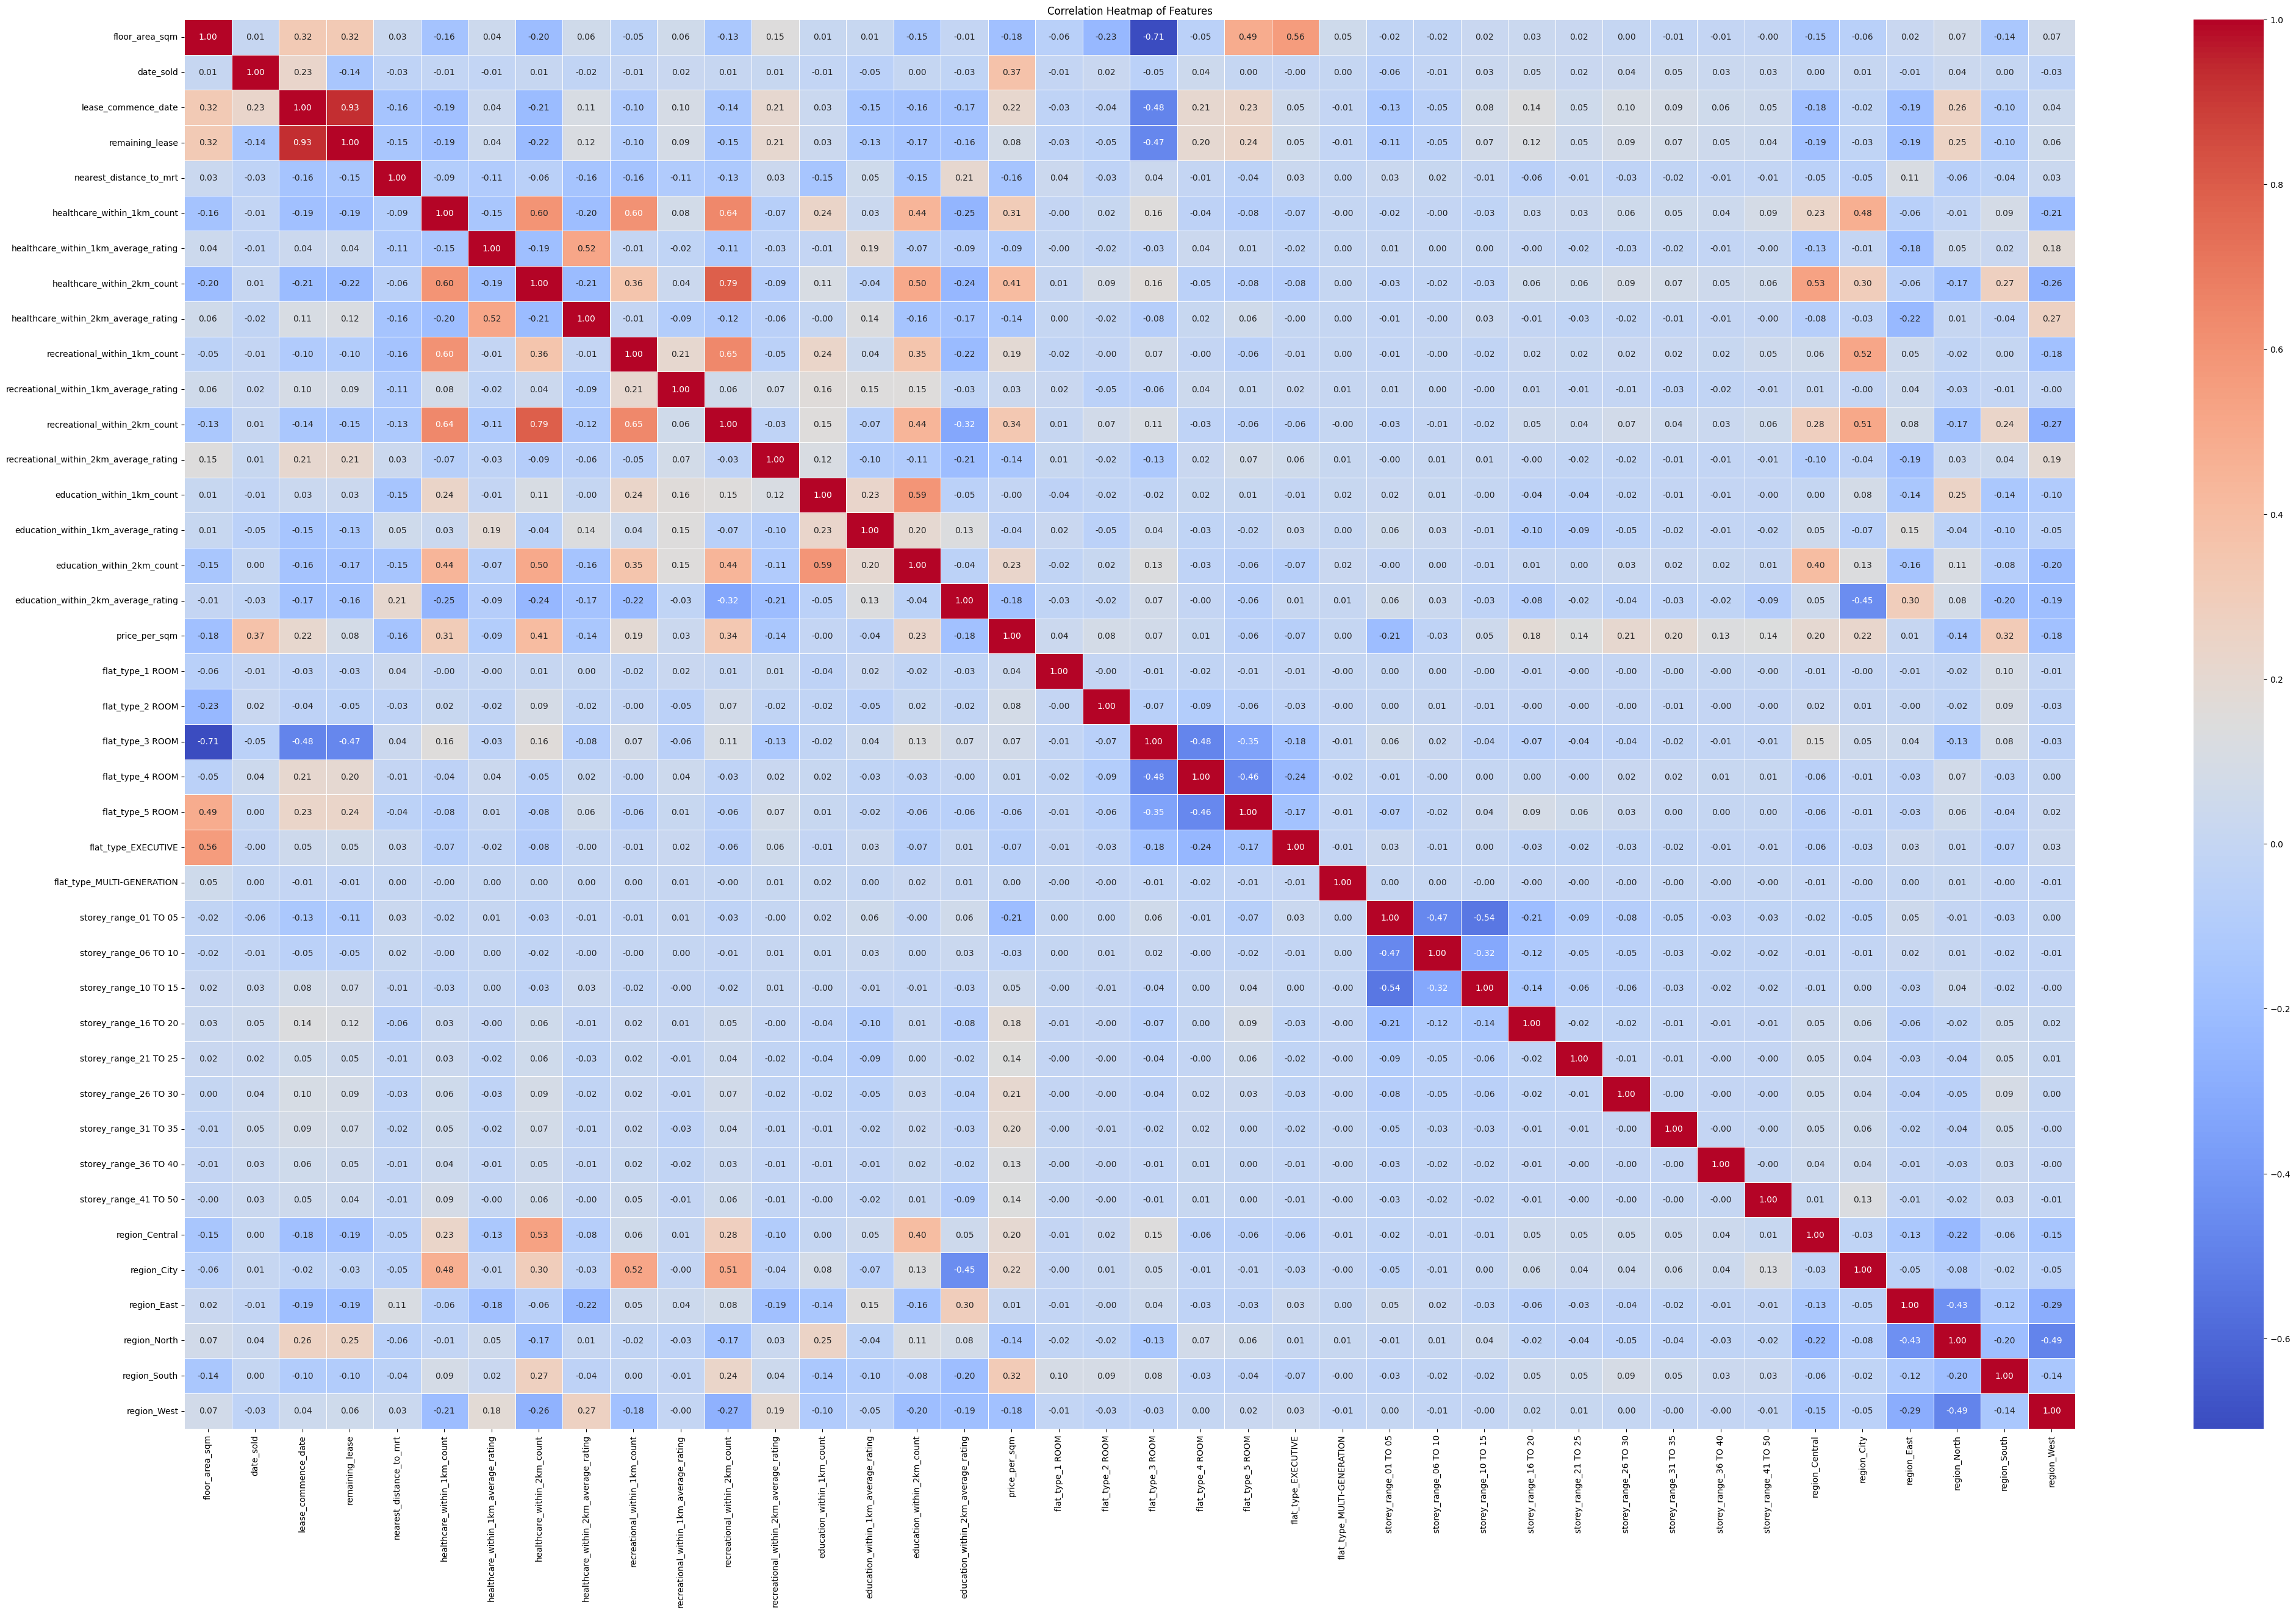

In [24]:
# Compute the correlation matrix
corr_matrix = X_train_encoded.corr()

# Set up the matplotlib figure
plt.figure(figsize=(50, 30))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)

# Add a title
plt.title('Correlation Heatmap of Features')

# Show the plot
plt.show()

In [25]:
# Drop Highly Correlated lease_commence_date (with remaining_lease)
X_train_numeric = X_train_numeric.drop(columns=['lease_commence_date'])
X_test_numeric = X_test_numeric.drop(columns=['lease_commence_date'])

In [26]:
# Initialize VarianceThreshold with the desired threshold
threshold = 0.05
selector = VarianceThreshold(threshold)

# Fit the selector to your data
selector.fit(X_train_numeric)

# Get the indices of all features
all_indices = range(len(X_train_numeric.columns))

# Get the indices of the features that are retained
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X_train_numeric.columns[selected_indices]

# Display the selected features
print("Selected features:", selected_features)

# Get the indices of the features that are not selected
not_selected_indices = list(set(all_indices) - set(selected_indices))

# Get the names of the features that are not selected
not_selected_features = X_train_numeric.columns[not_selected_indices]

# Display the features that are not selected
print("Not selected features:", not_selected_features)

Selected features: Index(['floor_area_sqm', 'remaining_lease', 'nearest_distance_to_mrt',
       'healthcare_within_1km_count', 'healthcare_within_1km_average_rating',
       'healthcare_within_2km_count', 'healthcare_within_2km_average_rating',
       'recreational_within_1km_count',
       'recreational_within_1km_average_rating',
       'recreational_within_2km_count', 'education_within_1km_count',
       'education_within_1km_average_rating', 'education_within_2km_count',
       'price_per_sqm', 'flat_type_3 ROOM', 'flat_type_4 ROOM',
       'flat_type_5 ROOM', 'flat_type_EXECUTIVE', 'storey_range_01 TO 05',
       'storey_range_06 TO 10', 'storey_range_10 TO 15', 'region_Central',
       'region_East', 'region_North', 'region_South', 'region_West'],
      dtype='object')
Not selected features: Index(['region_City', 'recreational_within_2km_average_rating',
       'education_within_2km_average_rating', 'flat_type_1 ROOM',
       'flat_type_2 ROOM', 'flat_type_MULTI-GENERATION',
   

In [27]:
# Keep selected features

# Transform your data to keep only the selected features
X_train_selected_array = selector.fit_transform(X_train_numeric)
X_test_selected_array = selector.transform(X_test_numeric)

# Convert the transformed data back to a DataFrame
X_train_selected = pd.DataFrame(X_train_selected_array, columns=selected_features)
X_test_selected = pd.DataFrame(X_test_selected_array, columns=selected_features)

print(X_train_selected.info())
print(X_test_selected.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253486 entries, 0 to 253485
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   floor_area_sqm                          253486 non-null  float64
 1   remaining_lease                         253486 non-null  float64
 2   nearest_distance_to_mrt                 253486 non-null  float64
 3   healthcare_within_1km_count             253486 non-null  float64
 4   healthcare_within_1km_average_rating    253486 non-null  float64
 5   healthcare_within_2km_count             253486 non-null  float64
 6   healthcare_within_2km_average_rating    253486 non-null  float64
 7   recreational_within_1km_count           253486 non-null  float64
 8   recreational_within_1km_average_rating  253486 non-null  float64
 9   recreational_within_2km_count           253486 non-null  float64
 10  education_within_1km_count              2534

## Machine Learning Modelling

### Regression Metrics

1. **Mean Absolute Error (MAE)**
   - Formula: $ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $
   - Description: The average of the absolute differences between the predicted values and actual values. It gives an idea of how wrong the predictions were.
   

2. **Mean Absolute Percentage Error (MAPE)**
   - Formula: $ \text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} |\frac{y_i - \hat{y}_i}{y_i}| $
   - Description: Provides an intuitive understanding of model's predictive accuracy relative to actual values. It measures the absolute percentage difference between the predicted values and the actual values.


3. **Mean Squared Error (MSE)**
   - Formula: $ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $
   - Description: The average of the squared differences between the predicted values and actual values. It penalizes larger errors more than MAE.


4. **Root Mean Squared Error (RMSE)**
   - Formula: $ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $
   - Description: The square root of the average of the squared differences between the predicted values and actual values. It is in the same units as the response variable and is sensitive to outliers.


5. **R-squared (Coefficient of Determination)**
   - Formula: $ R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} $
   - Description: The proportion of the variance in the dependent variable that is predictable from the independent variables. It provides a measure of how well observed outcomes are replicated by the model.



In [28]:
# Evaluation 
def evaluate(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    # mape = np.mean(np.abs((np.array(y_test) - np.array(y_pred)) / np.array(y_test))) * 100
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, y_pred)
    
    print("Mean Absolute Error (MAE):", mae)
    # print("Mean Absolute Percentage Error (MAPE):", mape)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared Coefficient (R^2):", r_squared)

In [29]:
# Features Used
feature_names = X_train_selected.columns

### Baseline Modelling 

We will trial a selected few baseline models to evaluate their performance before selecting the best baseline model to proceed with Hyperparameter Tuning and the subsequent Advanced Modelling which builds on top of Baseline Modelling.

##### Model Training

In [30]:
# Linear Regression
reg_lr = LinearRegression().fit(X_train_selected, y_train)
y_pred_lr = reg_lr.predict(X_test_selected)

evaluate(y_test, y_pred_lr)

Mean Absolute Error (MAE): 15997.76545680088
Mean Squared Error (MSE): 616453880.6893471
Root Mean Squared Error (RMSE): 24828.48929535076
R-squared Coefficient (R^2): 0.9715517505395238


In [31]:
# Decision Tree Regressor
reg_dtr = DecisionTreeRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_dtr = reg_dtr.predict(X_test_selected)

evaluate(y_test, y_pred_dtr)

Mean Absolute Error (MAE): 360.71496613251907
Mean Squared Error (MSE): 5185215.998973024
Root Mean Squared Error (RMSE): 2277.106936218197
R-squared Coefficient (R^2): 0.9997607115100318


Given Decision Tree Regressor outperforms Linear Regression as it has a greater R-Squared Coefficient of 0.99971 > 0.97155, we will be proceeding with Decision Tree Regressor as our baseline model.

##### Cross Validation

<Axes: title={'center': 'Decision Tree Learning Curve (MAPE)'}, xlabel='Training examples', ylabel='Score'>

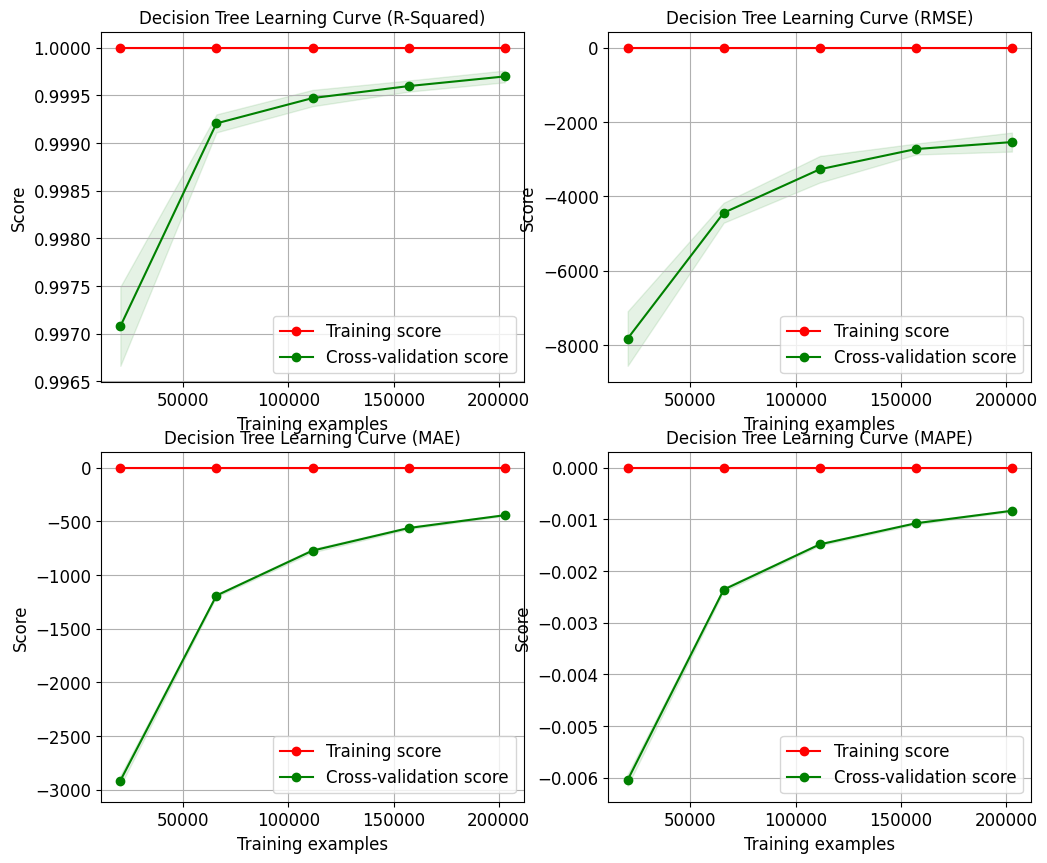

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
ax1, ax2, ax3, ax4 = axes.flatten() 

# Learning curves
skplt.estimators.plot_learning_curve(DecisionTreeRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="r2", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree Learning Curve (R-Squared)", ax=ax1)
skplt.estimators.plot_learning_curve(DecisionTreeRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_root_mean_squared_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree Learning Curve (RMSE)", ax=ax2)
skplt.estimators.plot_learning_curve(DecisionTreeRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree Learning Curve (MAE)", ax=ax3)
skplt.estimators.plot_learning_curve(DecisionTreeRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_percentage_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree Learning Curve (MAPE)", ax=ax4)

Training Score Curve shows the model's performance based on the training dataset as a function of the number of training examples used. Validation Score Curve shows the model's performance on a separate validation dataset as a function of the number of training examples used. 

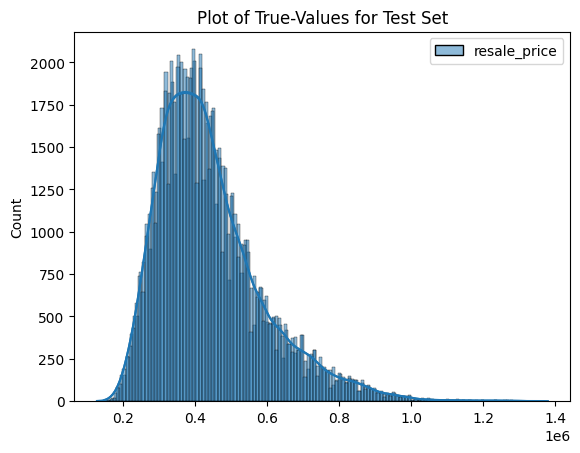

In [33]:
# Plot graph to visualise how far predictions are from true-values for test set
sns.histplot(y_test, label='true', color='red', kde=True)
sns.histplot(y_pred_dtr, label='predicted', kde=True)
plt.title("Plot of True-Values for Test Set")
plt.show()

In [34]:
# Print Text Representation of Decision Tree Regressor rules
text_representation_dtr = tree.export_text(reg_dtr)
print(text_representation_dtr)

|--- feature_0 <= 84.50
|   |--- feature_13 <= 5889.65
|   |   |--- feature_13 <= 4340.92
|   |   |   |--- feature_0 <= 74.50
|   |   |   |   |--- feature_13 <= 3752.77
|   |   |   |   |   |--- feature_13 <= 3418.55
|   |   |   |   |   |   |--- feature_0 <= 65.50
|   |   |   |   |   |   |   |--- feature_13 <= 3137.03
|   |   |   |   |   |   |   |   |--- feature_0 <= 62.50
|   |   |   |   |   |   |   |   |   |--- feature_14 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_9 <= 10.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_9 >  10.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [140000.00]
|   |   |   |   |   |   |   |   |   |--- feature_14 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_13 <= 2525.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_13 >  2525.00
|   |   |   |   |   |

##### Hyperparameter Tuning

In [35]:
# Decision Tree Model Parameters
reg_dtr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [36]:
# https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
    
# Use RandomSearch 
param_dist = {
    "max_depth": randint(1, 20),  
    "min_samples_split": randint(2, 40),  
    "min_samples_leaf": randint(1, 20), 
    "max_features": ["auto", "sqrt", "log2", None],
}

rscv_dtr = RandomizedSearchCV(estimator = DecisionTreeRegressor(random_state=42), param_distributions = param_dist, n_iter = 100, scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs = -1).fit(X_train_selected, y_train)

best_params_dtr = rscv_dtr.best_params_
print("Best Parameters For Decision Tree:", best_params_dtr)

y_pred_rscv_dtr = rscv_dtr.predict(X_test_selected)

evaluate(y_test, y_pred_rscv_dtr)

Best Parameters For Decision Tree: {'max_depth': 17, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 19}
Mean Absolute Error (MAE): 669.4268287860085
Mean Squared Error (MSE): 10107178.774810089
Root Mean Squared Error (RMSE): 3179.178946648032
R-squared Coefficient (R^2): 0.9995335716877864


In [37]:
# Use Grid Search
params = { 
    'max_depth': [5, 10, 12, 15, 17, 20],     
    'min_samples_split': [2, 5, 10, 15, 20, 40], 
    'min_samples_leaf': [1, 3, 5, 7, 10, 20],
    "max_features": ['auto', None],
}

gscv_dtr = GridSearchCV(estimator = DecisionTreeRegressor(random_state=42), param_grid = params, scoring = 'neg_root_mean_squared_error', n_jobs = -1).fit(X_train_selected, y_train)

best_params_dtr = gscv_dtr.best_params_
print("Best Parameters For Decision Tree:", best_params_dtr)

y_pred_gscv_dtr = gscv_dtr.predict(X_test_selected)

evaluate(y_test, y_pred_gscv_dtr)

KeyboardInterrupt: 

After Hyperparameter Tuning, the RMSE of the tuned model has decreased from 2504 to 2270 when compared to the model before Hyperparameter Tuning. The best hyperparameters are 'max_depth': 17, 'max_features': 'auto', 'min_samples_leaf': 1 and 'min_samples_split': 5.

##### Feature Evaluation

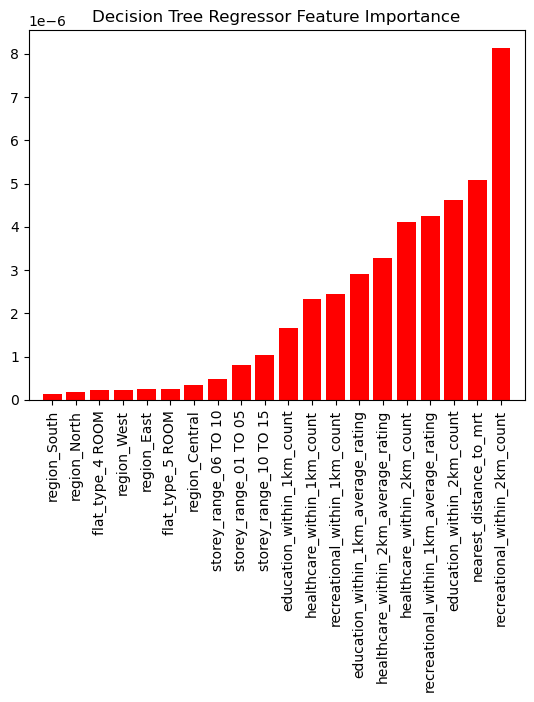

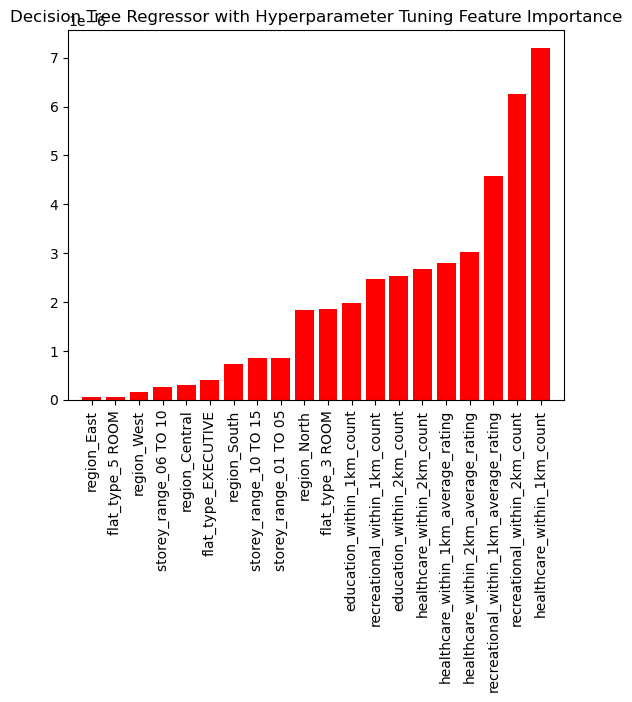

In [ ]:
# Feature Importance Visualisation
skplt.estimators.plot_feature_importances(reg_dtr, feature_names = feature_names,
                                         title="Decision Tree Regressor Feature Importance",
                                         x_tick_rotation=90, order="ascending");
skplt.estimators.plot_feature_importances(gscv_dtr.best_estimator_, feature_names = feature_names,
                                         title="Decision Tree Regressor with Hyperparameter Tuning Feature Importance",
                                         x_tick_rotation=90, order="ascending");

The Decision Tree Regressor Feature Importance plot displays the significance of each attribute in the regression model. The features, labeled on the x-axis, are ranked according to their importance scores on the y-axis. A higher bar denotes a greater influence on the model's predictions, with "recreational_within_2km_count" standing out as the most impactful feature in this particular model. However, after hyperparameter tuning, "healthcare_within_1km_count" stood out as the most impactful feature in this particular model.

### Advanced Modelling 

From the Baseline Decision Tree Model, we will look into more complex Ensemble models for better performance.

#### Random Forest Regressor

In [ ]:
# Random Forest Regressor
reg_rfr = RandomForestRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_rfr = reg_rfr.predict(X_test_selected)

evaluate(y_test, y_pred_rfr)

Mean Absolute Error (MAE): 251.47289441513638
Mean Squared Error (MSE): 4011083.9197759186
Root Mean Squared Error (RMSE): 2002.7690630164823
R-squared Coefficient (R^2): 0.9998148956158259


##### Cross Validation

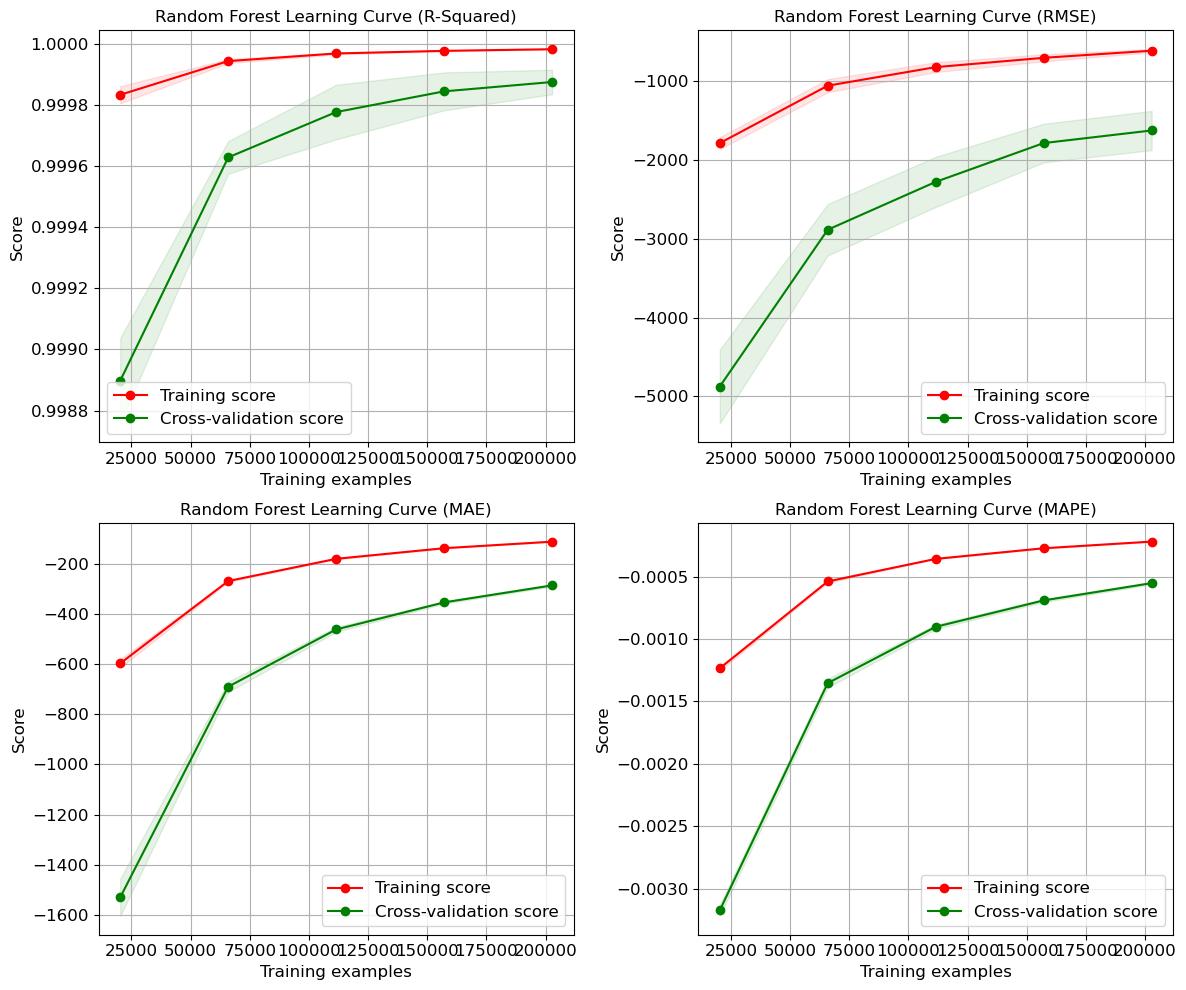

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
ax1, ax2, ax3, ax4 = axes.flatten() 
y_train_reshaped = np.ravel(y_train)

# Learning curves
skplt.estimators.plot_learning_curve(RandomForestRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="r2", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="Random Forest Learning Curve (R-Squared)", ax=ax1)
skplt.estimators.plot_learning_curve(RandomForestRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="neg_root_mean_squared_error", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="Random Forest Learning Curve (RMSE)", ax=ax2)
skplt.estimators.plot_learning_curve(RandomForestRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="neg_mean_absolute_error", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="Random Forest Learning Curve (MAE)", ax=ax3)
skplt.estimators.plot_learning_curve(RandomForestRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="neg_mean_absolute_percentage_error", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="Random Forest Learning Curve (MAPE)", ax=ax4)

plt.tight_layout()
plt.show()



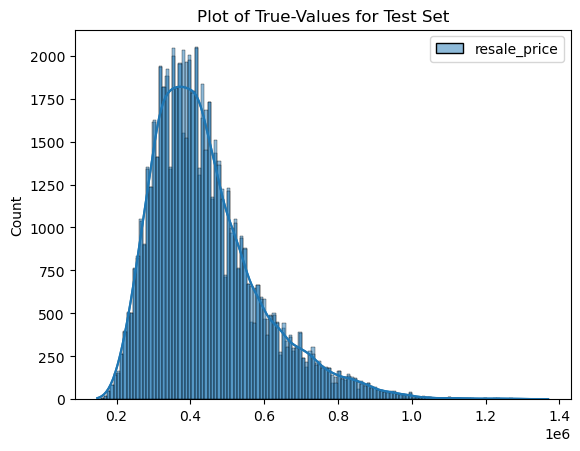

In [ ]:
# Plot graph to visualise how far predictions are from true-values for test set
sns.histplot(y_test, label='true', color='red', kde=True)
sns.histplot(y_pred_rfr, label='predicted', kde=True)
plt.title("Plot of True-Values for Test Set")
plt.show()

##### Hyperparameter Tuning

In [ ]:
# Random Forest Model Parameters
reg_rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Use Grid Search
n_estimators = [100]
max_depth = [None, 10, 20]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ['auto', 'sqrt', 'log2']

y_train_reshaped = np.ravel(y_train)

params = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_features': max_features
}

gscv_rfr = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                        param_grid=params, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=-1)
gscv_rfr.fit(X_train_selected, y_train_reshaped)

best_params_rfr = gscv_rfr.best_params_
print("Best Parameters For Random Forest:", best_params_rfr)

y_pred_gscv_rfr = gscv_rfr.predict(X_test_selected)

evaluate(y_test, y_pred_gscv_rfr)


Best Parameters For Random Forest: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean Absolute Error (MAE): 251.47289441513638
Mean Squared Error (MSE): 4011083.9197759186
Root Mean Squared Error (RMSE): 2002.7690630164823
R-squared Coefficient (R^2): 0.9998148956158259


In [ ]:
y_train_reshaped = np.ravel(y_train)

params = { 
    'max_depth': [5, 10, 12, 15, 17, 20],     
    'min_samples_split': [2, 5, 10, 15, 20, 40], 
    'min_samples_leaf': [1, 3, 5, 7, 10, 20],
    "max_features": ['auto', None],
}

gscv_rfr = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                        param_grid=params, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=-1)
gscv_rfr.fit(X_train_selected, y_train_reshaped)

best_params_rfr = gscv_rfr.best_params_
print("Best Parameters For Random Forest:", best_params_rfr)

y_pred_gscv_rfr = gscv_rfr.predict(X_test_selected)

evaluate(y_test, y_pred_gscv_rfr)

Best Parameters For Random Forest: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean Absolute Error (MAE): 250.03361383760472
Mean Squared Error (MSE): 3891485.9174014186
Root Mean Squared Error (RMSE): 1972.6849513800776
R-squared Coefficient (R^2): 0.9998204148507811


After Hyperparameter Tuning, the RMSE of the tuned model has [increased/decreased] from [value] to [value] when compared to the model before Hyperparameter Tuning. The best hyperparameters are [params].

##### Feature Evaluation

In [ ]:
# Feature Importance Visualisation
skplt.estimators.plot_feature_importances(reg_rfr, feature_names = feature_names,
                                         title="Random Forest Regressor Feature Importance",
                                         x_tick_rotation=90, order="ascending");
skplt.estimators.plot_feature_importances(gscv_rfr.best_estimator_, feature_names = feature_names,
                                         title="Random Forest Regressor with Hyperparameter Tuning Feature Importance",
                                         x_tick_rotation=90, order="ascending");

The Random Forest Regressor Feature Importance plot displays the significance of each attribute in the regression model. A higher bar denotes a greater influence on the model's predictions, with "feature_name" standing out as the most impactful feature in this particular model. However, after hyperparameter tuning, "feature_name" stood out as the most impactful feature in this particular model.

#### XGBoost Regressor

In [38]:
reg_xgbr = XGBRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_xgbr = reg_xgbr.predict(X_test_selected)

evaluate(y_test, y_pred_xgbr)

Mean Absolute Error (MAE): 2372.772940770372
Mean Squared Error (MSE): 19901136.969587162
Root Mean Squared Error (RMSE): 4461.06903887254
R-squared Coefficient (R^2): 0.9990815979478873


##### Cross Validation

<Axes: title={'center': 'XGBoost Learning Curve (MAPE)'}, xlabel='Training examples', ylabel='Score'>

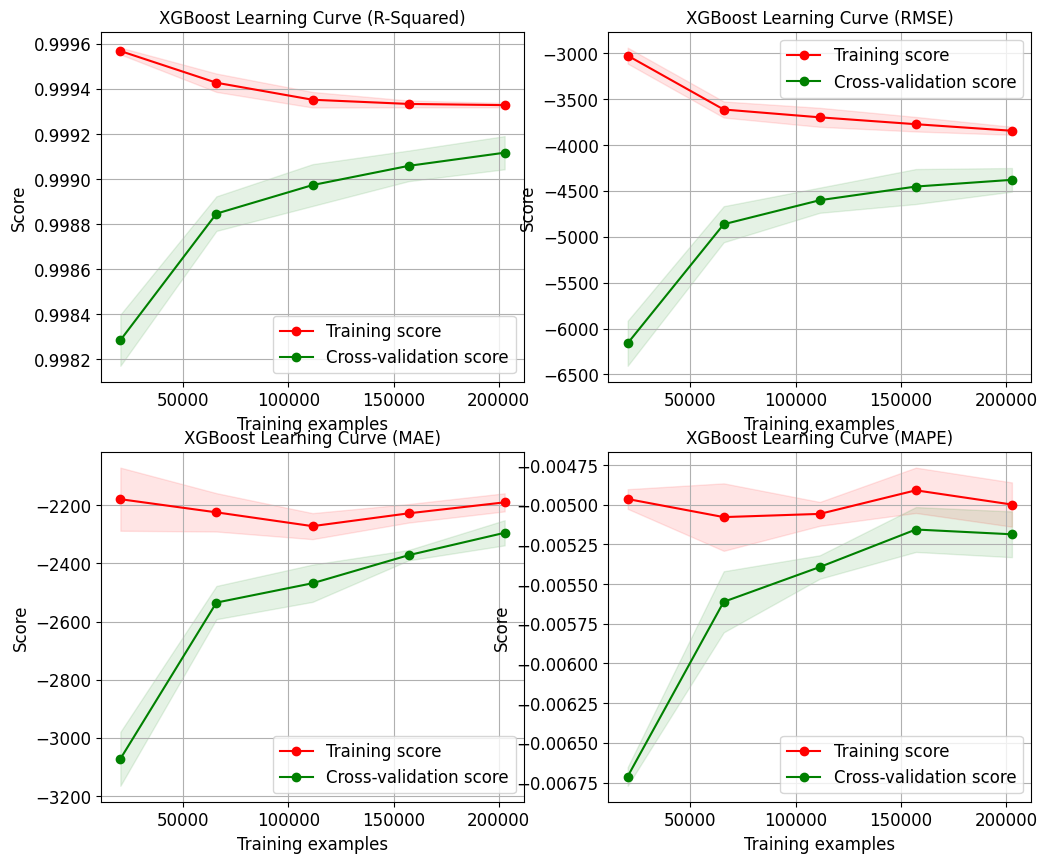

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
ax1, ax2, ax3, ax4 = axes.flatten() 

cv_xgbr = XGBRegressor(random_state=42)

# Learning curves
skplt.estimators.plot_learning_curve(cv_xgbr, X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="r2", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="XGBoost Learning Curve (R-Squared)", ax=ax1)
skplt.estimators.plot_learning_curve(cv_xgbr, X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_root_mean_squared_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="XGBoost Learning Curve (RMSE)", ax=ax2)
skplt.estimators.plot_learning_curve(cv_xgbr, X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="XGBoost Learning Curve (MAE)", ax=ax3)
skplt.estimators.plot_learning_curve(cv_xgbr, X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_percentage_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="XGBoost Learning Curve (MAPE)", ax=ax4)

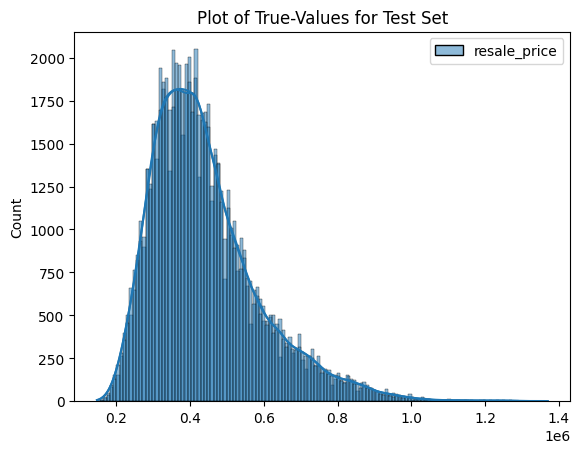

In [40]:
# Plot graph to visualise how far predictions are from true-values for test set
sns.histplot(y_test, label='true', color='red', kde=True)
sns.histplot(y_pred_xgbr, label='predicted', kde=True)
plt.title("Plot of True-Values for Test Set")
plt.show()

##### Hyperparameter Tuning

In [41]:
# XGBoost Model Parameters
reg_xgbr.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [42]:
# https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d
# Define the hyperparameter distributions
param_dist = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.1),
    'subsample': uniform(0.5, 0.5),
    #'n_estimators':randint(50, 200)
}

rscv_xgb = RandomizedSearchCV(estimator= XGBRegressor(random_state=42), param_distributions=param_dist, n_iter=100, scoring='neg_root_mean_squared_error', cv = 5, n_jobs = -1).fit(X_train_selected, y_train)

best_params_xgb = rscv_xgb.best_params_
print("Best Parameters for XGBoost: ", best_params_xgb)

y_pred_rscv_xgb = rscv_xgb.predict(X_test_selected)

evaluate(y_test, y_pred_rscv_xgb)

Best Parameters for XGBoost:  {'learning_rate': 0.0818036942368601, 'max_depth': 9, 'subsample': 0.9853641727296615}
Mean Absolute Error (MAE): 1099.8641196920562
Mean Squared Error (MSE): 11896747.449603006
Root Mean Squared Error (RMSE): 3449.166196286141
R-squared Coefficient (R^2): 0.9994509862784283


In [48]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [5, 10, 12, 15, 17, 20],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}
gscv_xgb = GridSearchCV(estimator=XGBRegressor(random_state=42), param_grid = param_grid, scoring = 'neg_root_mean_squared_error', n_jobs = -1).fit(X_train_selected, y_train)

best_params_xgb = gscv_xgb.best_params_
print("Best Parameters for XGBoost: ", best_params_xgb)

y_pred_gscv_xgb = gscv_xgb.predict(X_test_selected)

evaluate(y_test, y_pred_gscv_xgb)

Best Parameters for XGBoost:  {'learning_rate': 0.1, 'max_depth': 10, 'subsample': 1}
Mean Absolute Error (MAE): 988.4249036344916
Mean Squared Error (MSE): 12171310.6114664
Root Mean Squared Error (RMSE): 3488.7405480296757
R-squared Coefficient (R^2): 0.9994383156771619


After Hyperparameter Tuning, the RMSE of the tuned model has [increased/decreased] from [value] to [value] when compared to the model before Hyperparameter Tuning. The best hyperparameters are [params].

##### Feature Evaluation

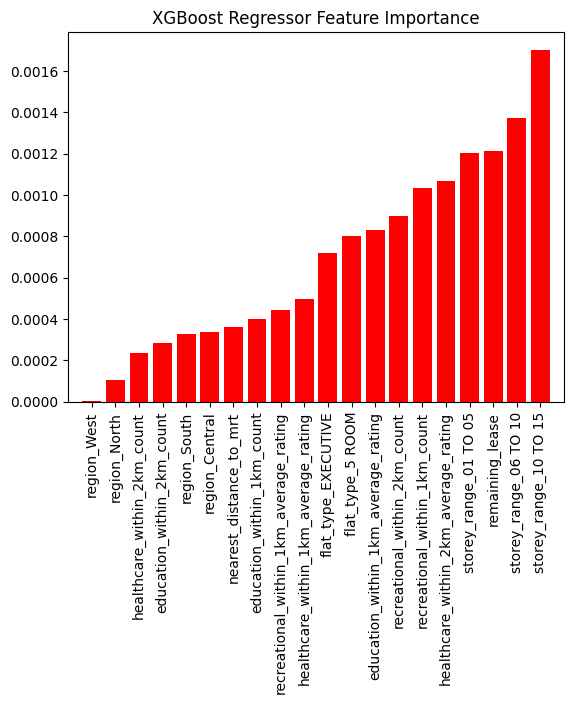

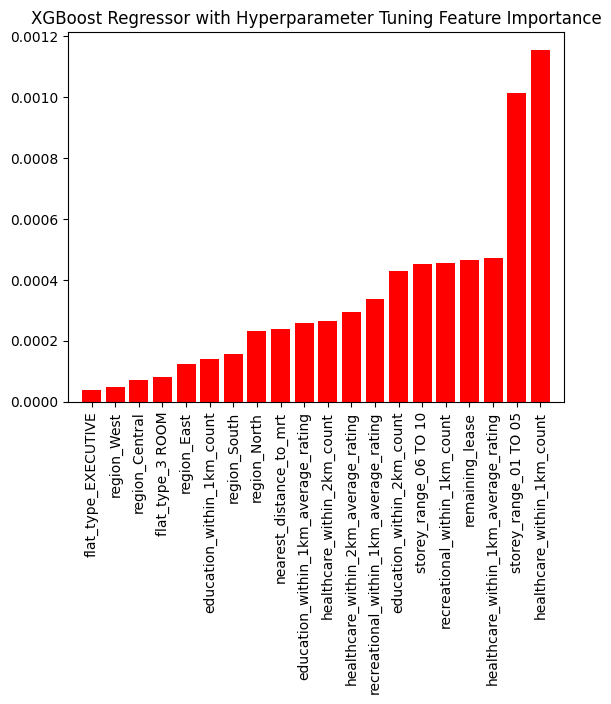

In [43]:
# Feature Importance Visualisation
skplt.estimators.plot_feature_importances(reg_xgbr, feature_names = feature_names,
                                         title="XGBoost Regressor Feature Importance",
                                         x_tick_rotation=90, order="ascending");
skplt.estimators.plot_feature_importances(rscv_xgb.best_estimator_, feature_names = feature_names,
                                         title="XGBoost Regressor with Hyperparameter Tuning Feature Importance",
                                         x_tick_rotation=90, order='ascending');

The XG Boost Regressor Feature Importance plot displays the significance of each attribute in the regression model. A higher bar denotes a greater influence on the model's predictions, with "feature_name" standing out as the most impactful feature in this particular model. However, after hyperparameter tuning, "feature_name" stood out as the most impactful feature in this particular model.

#### LightGBM Regressor

In [ ]:
reg_lgbmr = lgb.LGBMRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_lgbmr = reg_lgbmr.predict(X_test_selected)

evaluate(y_test, y_pred_lgbmr)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1951
[LightGBM] [Info] Number of data points in the train set: 253486, number of used features: 26
[LightGBM] [Info] Start training from score 441218.283720
Mean Absolute Error (MAE): 2670.081639494893
Mean Squared Error (MSE): 24148170.204100728
Root Mean Squared Error (RMSE): 4914.078774714619
R-squared Coefficient (R^2): 0.9988856049227688


##### Cross Validation

<Axes: title={'center': 'LightGBM Learning Curve (MAPE)'}, xlabel='Training examples', ylabel='Score'>

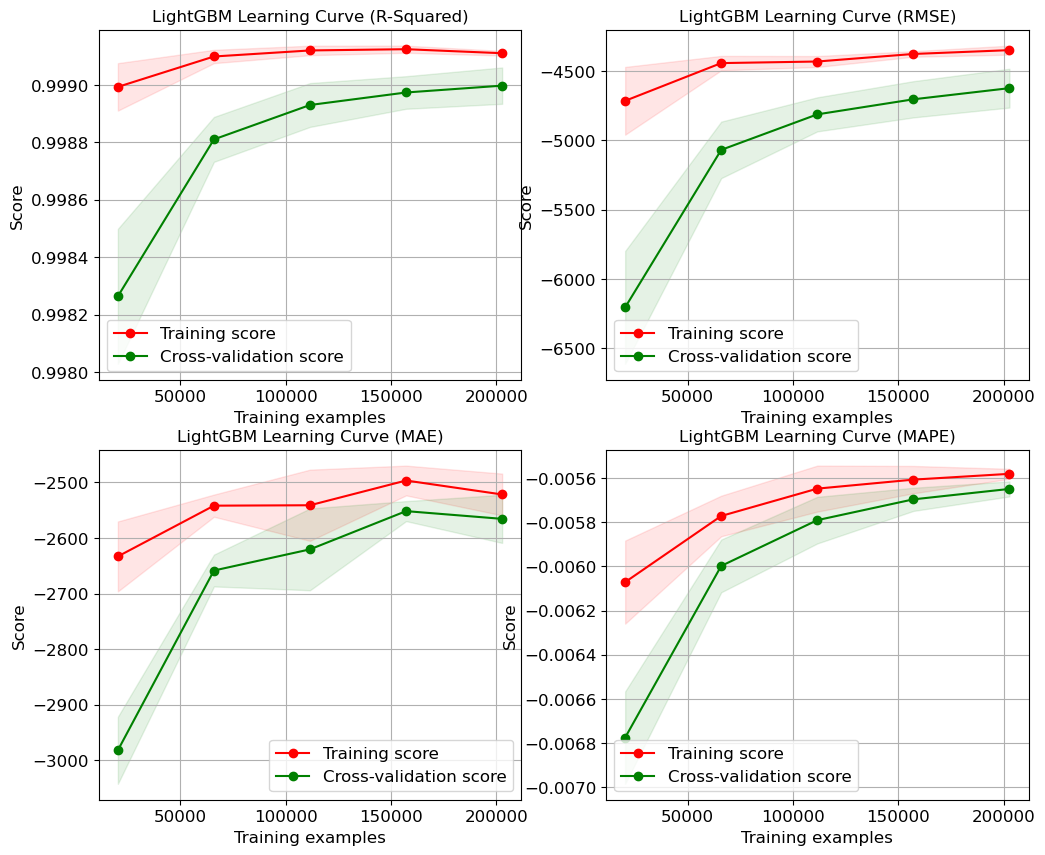

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
ax1, ax2, ax3, ax4 = axes.flatten() 

cv_lgmbr = lgb.LGBMRegressor(random_state=42)

# Learning curves
skplt.estimators.plot_learning_curve(cv_lgmbr, X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="r2", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="LightGBM Learning Curve (R-Squared)", ax=ax1)
skplt.estimators.plot_learning_curve(cv_lgmbr, X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_root_mean_squared_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="LightGBM Learning Curve (RMSE)", ax=ax2)
skplt.estimators.plot_learning_curve(cv_lgmbr, X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="LightGBM Learning Curve (MAE)", ax=ax3)
skplt.estimators.plot_learning_curve(cv_lgmbr, X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_percentage_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="LightGBM Learning Curve (MAPE)", ax=ax4)

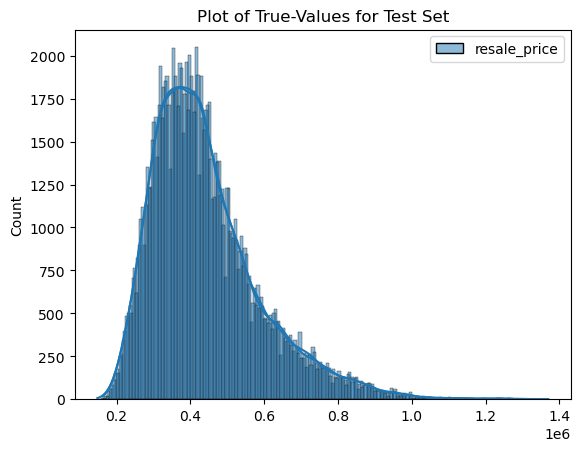

In [ ]:
# Plot graph to visualise how far predictions are from true-values for test set
sns.histplot(y_test, label='true', color='red', kde=True)
sns.histplot(y_pred_lgmbr, label='predicted', kde=True)
plt.title("Plot of True-Values for Test Set")
plt.show()

##### Hyperparameter Tuning

In [ ]:
reg_lgbmr.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# num_leaves shoud be < 2^(max_depth)

# random search
params = { 
    'max_depth': [4, 5, 6, 7, 8, 9, 10],
    'num_leaves': randint(5, 500),
    'min_data_in_leaf': randint(5, 500),
    'learning_rate': [0.01, 0.05, 0.10, 0.50],
}

rand_search_lgbm = RandomizedSearchCV(estimator = lgb.LGBMRegressor(random_state=42), param_distributions = params,
                                       scoring = 'neg_root_mean_squared_error', n_jobs = -1).fit(X_train_selected, y_train)

best_params_lgbm = rand_search_lgbm.best_params_
print("Best Parameters For LightGBM:", best_params_lgbm)

y_pred_gscv_cbr = rand_search_lgbm.predict(X_test_selected)

evaluate(y_test, y_pred_gscv_cbr)

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1951
[LightGBM] [Info] Number of data points in the train set: 253486, number of used features: 26
[LightGBM] [Info] Start training from score 441218.283720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

After Hyperparameter Tuning, the RMSE of the tuned model has decreased from 4914 to 4005 when compared to the model before Hyperparameter Tuning. The best hyperparameters are 'learning_rate': 0.1, 'max_depth': 8, 'min_data_in_leaf': 15 and 'num_leaves': 82.

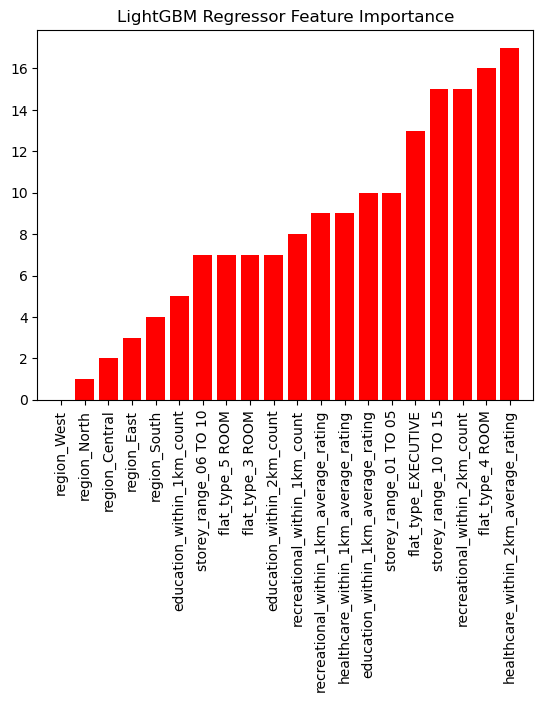

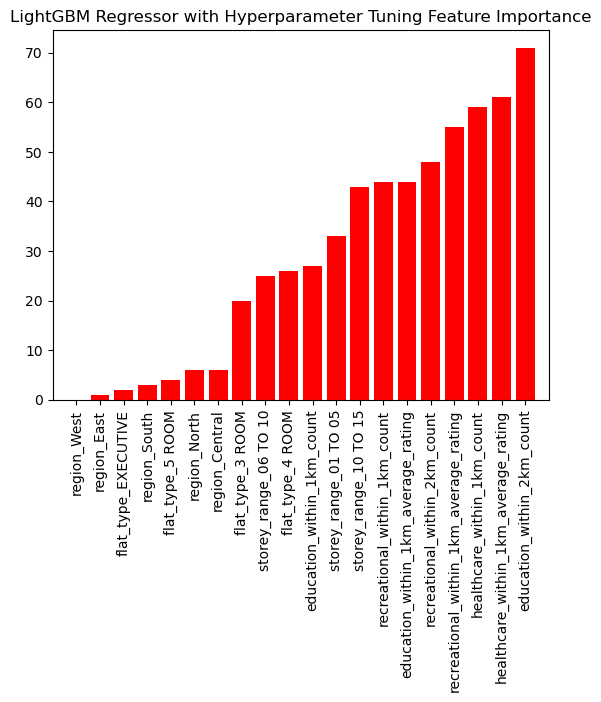

In [ ]:
# Feature Importance Visualisation
skplt.estimators.plot_feature_importances(reg_lgbmr, feature_names = feature_names,
                                         title="LightGBM Regressor Feature Importance",
                                         x_tick_rotation=90, order="ascending");
skplt.estimators.plot_feature_importances(rand_search_lgbm.best_estimator_, feature_names = feature_names,
                                         title="LightGBM Regressor with Hyperparameter Tuning Feature Importance",
                                         x_tick_rotation=90, order="ascending");

The LightGBM Regressor Feature Importance plot displays the significance of each attribute in the regression model, where a higher bar would denote that the attriubute a greater influence on the model's predictions. For this model, "healthcare_within_2km_average_rating" stands out as the most impactful feature. However, after hyperparameter tuning, "education_within_2km_count" seems to be the most impactful feature.

#### CatBoost Regressor

In [ ]:
reg_cbr = cb.CatBoostRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_cbr = reg_cbr.predict(X_test_selected)

evaluate(y_test, y_pred_cbr)

Learning rate set to 0.098176
0:	learn: 133983.2227914	total: 184ms	remaining: 3m 3s
1:	learn: 122654.4395760	total: 222ms	remaining: 1m 50s
2:	learn: 112508.1002723	total: 253ms	remaining: 1m 24s
3:	learn: 103346.2128993	total: 284ms	remaining: 1m 10s
4:	learn: 95017.0975006	total: 317ms	remaining: 1m 3s
5:	learn: 87522.9638465	total: 348ms	remaining: 57.7s
6:	learn: 80797.4608775	total: 381ms	remaining: 54s
7:	learn: 74685.5959329	total: 429ms	remaining: 53.2s
8:	learn: 68932.5361395	total: 463ms	remaining: 51s
9:	learn: 63921.7280263	total: 511ms	remaining: 50.6s
10:	learn: 59182.0566974	total: 566ms	remaining: 50.9s
11:	learn: 54852.7804771	total: 605ms	remaining: 49.8s
12:	learn: 51014.8502410	total: 644ms	remaining: 48.9s
13:	learn: 47415.3719573	total: 686ms	remaining: 48.3s
14:	learn: 44158.1201672	total: 724ms	remaining: 47.5s
15:	learn: 41170.5849796	total: 762ms	remaining: 46.9s
16:	learn: 38471.5843847	total: 801ms	remaining: 46.3s
17:	learn: 36070.4875304	total: 847ms	rema

156:	learn: 5170.4238817	total: 6.68s	remaining: 35.9s
157:	learn: 5157.4536138	total: 6.73s	remaining: 35.8s
158:	learn: 5149.9309871	total: 6.76s	remaining: 35.8s
159:	learn: 5136.7454140	total: 6.8s	remaining: 35.7s
160:	learn: 5128.0464822	total: 6.85s	remaining: 35.7s
161:	learn: 5118.6866603	total: 6.89s	remaining: 35.6s
162:	learn: 5112.9978822	total: 6.93s	remaining: 35.6s
163:	learn: 5108.0351889	total: 6.97s	remaining: 35.6s
164:	learn: 5094.4830030	total: 7.02s	remaining: 35.5s
165:	learn: 5088.3970240	total: 7.07s	remaining: 35.5s
166:	learn: 5078.7864230	total: 7.11s	remaining: 35.5s
167:	learn: 5068.9470920	total: 7.17s	remaining: 35.5s
168:	learn: 5059.8939049	total: 7.21s	remaining: 35.5s
169:	learn: 5045.9648634	total: 7.25s	remaining: 35.4s
170:	learn: 5039.3173506	total: 7.29s	remaining: 35.4s
171:	learn: 5030.6831669	total: 7.34s	remaining: 35.3s
172:	learn: 5012.9910646	total: 7.39s	remaining: 35.3s
173:	learn: 5008.3433891	total: 7.43s	remaining: 35.3s
174:	learn:

310:	learn: 4061.6720831	total: 13.8s	remaining: 30.5s
311:	learn: 4059.4346717	total: 13.8s	remaining: 30.5s
312:	learn: 4055.1278805	total: 13.9s	remaining: 30.4s
313:	learn: 4050.3867566	total: 13.9s	remaining: 30.4s
314:	learn: 4042.9356478	total: 13.9s	remaining: 30.3s
315:	learn: 4040.8265776	total: 14s	remaining: 30.2s
316:	learn: 4036.5216491	total: 14s	remaining: 30.2s
317:	learn: 4033.6717061	total: 14.1s	remaining: 30.1s
318:	learn: 4031.2339484	total: 14.1s	remaining: 30.1s
319:	learn: 4029.7272353	total: 14.1s	remaining: 30s
320:	learn: 4024.7178089	total: 14.2s	remaining: 30s
321:	learn: 4020.9375065	total: 14.2s	remaining: 29.9s
322:	learn: 4016.4096477	total: 14.2s	remaining: 29.8s
323:	learn: 4012.7599331	total: 14.3s	remaining: 29.8s
324:	learn: 4009.6956704	total: 14.3s	remaining: 29.7s
325:	learn: 4006.4918418	total: 14.4s	remaining: 29.7s
326:	learn: 4003.0951553	total: 14.4s	remaining: 29.6s
327:	learn: 4000.8592944	total: 14.4s	remaining: 29.6s
328:	learn: 3998.0

461:	learn: 3632.3233556	total: 19.9s	remaining: 23.2s
462:	learn: 3630.2177140	total: 20s	remaining: 23.2s
463:	learn: 3628.0458283	total: 20s	remaining: 23.1s
464:	learn: 3625.9834813	total: 20s	remaining: 23.1s
465:	learn: 3624.9495212	total: 20.1s	remaining: 23s
466:	learn: 3623.1449095	total: 20.1s	remaining: 23s
467:	learn: 3621.9903166	total: 20.2s	remaining: 22.9s
468:	learn: 3620.0451181	total: 20.2s	remaining: 22.9s
469:	learn: 3617.0727095	total: 20.2s	remaining: 22.8s
470:	learn: 3616.5074745	total: 20.3s	remaining: 22.8s
471:	learn: 3615.1343303	total: 20.3s	remaining: 22.7s
472:	learn: 3612.6255408	total: 20.4s	remaining: 22.7s
473:	learn: 3610.7475338	total: 20.4s	remaining: 22.7s
474:	learn: 3608.9541581	total: 20.5s	remaining: 22.6s
475:	learn: 3607.8537392	total: 20.5s	remaining: 22.6s
476:	learn: 3605.8334522	total: 20.5s	remaining: 22.5s
477:	learn: 3603.9581692	total: 20.6s	remaining: 22.5s
478:	learn: 3600.6589537	total: 20.6s	remaining: 22.4s
479:	learn: 3598.756

613:	learn: 3375.8494832	total: 26.4s	remaining: 16.6s
614:	learn: 3375.1169031	total: 26.5s	remaining: 16.6s
615:	learn: 3374.4334257	total: 26.5s	remaining: 16.5s
616:	learn: 3373.7397186	total: 26.5s	remaining: 16.5s
617:	learn: 3371.0920831	total: 26.6s	remaining: 16.4s
618:	learn: 3369.0780560	total: 26.7s	remaining: 16.4s
619:	learn: 3367.2533009	total: 26.7s	remaining: 16.4s
620:	learn: 3366.4336143	total: 26.8s	remaining: 16.3s
621:	learn: 3364.4838376	total: 26.8s	remaining: 16.3s
622:	learn: 3362.7408742	total: 26.9s	remaining: 16.3s
623:	learn: 3359.6194146	total: 26.9s	remaining: 16.2s
624:	learn: 3357.2013965	total: 27s	remaining: 16.2s
625:	learn: 3355.5828303	total: 27s	remaining: 16.1s
626:	learn: 3354.4683011	total: 27.1s	remaining: 16.1s
627:	learn: 3353.0320675	total: 27.1s	remaining: 16.1s
628:	learn: 3351.7444108	total: 27.2s	remaining: 16s
629:	learn: 3349.7446748	total: 27.2s	remaining: 16s
630:	learn: 3348.7852193	total: 27.3s	remaining: 16s
631:	learn: 3347.457

764:	learn: 3191.4902264	total: 32.9s	remaining: 10.1s
765:	learn: 3190.8359780	total: 33s	remaining: 10.1s
766:	learn: 3190.4002250	total: 33.1s	remaining: 10s
767:	learn: 3189.0579660	total: 33.1s	remaining: 10s
768:	learn: 3188.4957334	total: 33.2s	remaining: 9.96s
769:	learn: 3187.9198229	total: 33.2s	remaining: 9.92s
770:	learn: 3187.1823369	total: 33.3s	remaining: 9.88s
771:	learn: 3186.7333247	total: 33.3s	remaining: 9.84s
772:	learn: 3185.7909432	total: 33.4s	remaining: 9.8s
773:	learn: 3185.0699387	total: 33.4s	remaining: 9.76s
774:	learn: 3183.8425587	total: 33.5s	remaining: 9.72s
775:	learn: 3182.4661809	total: 33.5s	remaining: 9.68s
776:	learn: 3181.9178993	total: 33.6s	remaining: 9.64s
777:	learn: 3181.3481963	total: 33.6s	remaining: 9.59s
778:	learn: 3180.3923182	total: 33.7s	remaining: 9.55s
779:	learn: 3179.8447686	total: 33.7s	remaining: 9.51s
780:	learn: 3178.5617462	total: 33.8s	remaining: 9.46s
781:	learn: 3177.5798687	total: 33.8s	remaining: 9.42s
782:	learn: 3176.

919:	learn: 3066.2919323	total: 39.5s	remaining: 3.44s
920:	learn: 3065.8398975	total: 39.6s	remaining: 3.4s
921:	learn: 3065.2297054	total: 39.6s	remaining: 3.35s
922:	learn: 3064.3102049	total: 39.7s	remaining: 3.31s
923:	learn: 3063.2907525	total: 39.7s	remaining: 3.27s
924:	learn: 3062.8201339	total: 39.7s	remaining: 3.22s
925:	learn: 3062.2404981	total: 39.8s	remaining: 3.18s
926:	learn: 3061.7890240	total: 39.9s	remaining: 3.14s
927:	learn: 3060.7464566	total: 39.9s	remaining: 3.1s
928:	learn: 3059.7625833	total: 39.9s	remaining: 3.05s
929:	learn: 3059.2399526	total: 40s	remaining: 3.01s
930:	learn: 3058.7041830	total: 40.1s	remaining: 2.97s
931:	learn: 3058.1637819	total: 40.1s	remaining: 2.93s
932:	learn: 3057.5392955	total: 40.2s	remaining: 2.88s
933:	learn: 3056.9334338	total: 40.2s	remaining: 2.84s
934:	learn: 3056.2754996	total: 40.2s	remaining: 2.8s
935:	learn: 3055.6281692	total: 40.3s	remaining: 2.76s
936:	learn: 3054.4280790	total: 40.4s	remaining: 2.71s
937:	learn: 305

##### Cross Validation

<AxesSubplot:title={'center':'Cat Boost Learning Curve (MAPE)'}, xlabel='Training examples', ylabel='Score'>

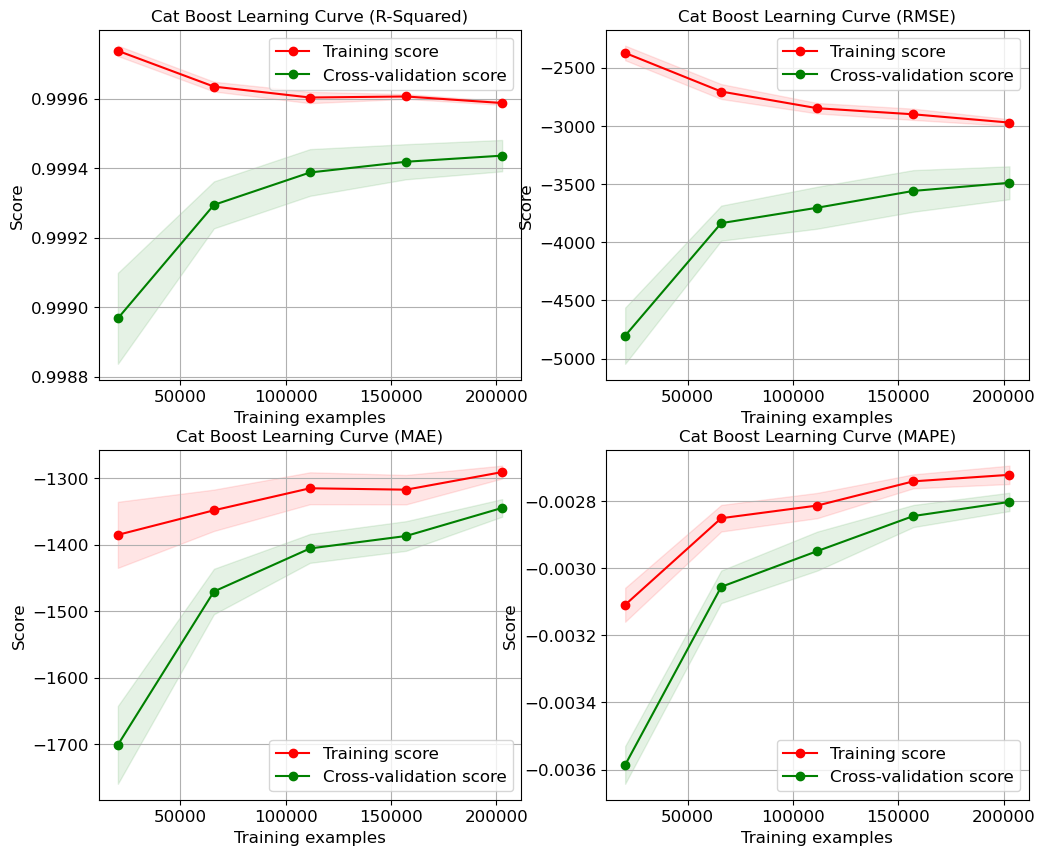

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
ax1, ax2, ax3, ax4 = axes.flatten() 

# Learning curves
skplt.estimators.plot_learning_curve(cb.CatBoostRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="r2", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Cat Boost Learning Curve (R-Squared)", ax=ax1)
skplt.estimators.plot_learning_curve(cb.CatBoostRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_root_mean_squared_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Cat Boost Learning Curve (RMSE)", ax=ax2)
skplt.estimators.plot_learning_curve(cb.CatBoostRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Cat Boost Learning Curve (MAE)", ax=ax3)
skplt.estimators.plot_learning_curve(cb.CatBoostRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_percentage_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Cat Boost Learning Curve (MAPE)", ax=ax4)

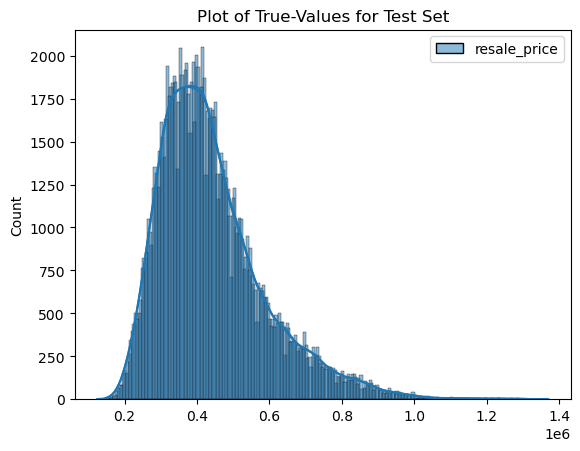

In [ ]:
# Plot graph to visualise how far predictions are from true-values for test set
sns.histplot(y_test, label='true', color='red', kde=True)
sns.histplot(y_pred_cbr, label='predicted', kde=True)
plt.title("Plot of True-Values for Test Set")
plt.show()

##### Hyperparameter Tuning

In [ ]:
# https://catboost.ai/en/docs/concepts/python-reference_catboostregressor

# Cat Boost Model Parameters
reg_cbr.get_params()

{'loss_function': 'RMSE', 'random_state': 42}

In [ ]:
# https://catboost.ai/en/docs/concepts/parameter-tuning

# Use GridSearch 
params = { 
    'learning_rate': [0.10, 0.50],
    'depth': [4, 5, 6, 7, 8, 9, 10],
    'subsample': [0.66, 0.8],
}

gscv_cbr = GridSearchCV(estimator = cb.CatBoostRegressor(random_state=42), param_grid = params, scoring = 'neg_root_mean_squared_error', n_jobs = -1).fit(X_train_selected, y_train)

best_params_cbr = gscv_cbr.best_params_
print("Best Parameters For Cat Boost:", best_params_cbr)

y_pred_gscv_cbr = gscv_cbr.predict(X_test_selected)

evaluate(y_test, y_pred_gscv_cbr)

0:	learn: 133607.3267260	total: 136ms	remaining: 2m 15s
1:	learn: 122077.9154475	total: 262ms	remaining: 2m 10s
2:	learn: 111526.4063744	total: 362ms	remaining: 2m
3:	learn: 101923.2510020	total: 443ms	remaining: 1m 50s
4:	learn: 93277.4704968	total: 519ms	remaining: 1m 43s
5:	learn: 85343.6177271	total: 603ms	remaining: 1m 39s
6:	learn: 78244.4857235	total: 687ms	remaining: 1m 37s
7:	learn: 71866.9160551	total: 763ms	remaining: 1m 34s
8:	learn: 66134.7726504	total: 832ms	remaining: 1m 31s
9:	learn: 60879.7485135	total: 896ms	remaining: 1m 28s
10:	learn: 56226.8704973	total: 968ms	remaining: 1m 27s
11:	learn: 51882.6319867	total: 1.03s	remaining: 1m 24s
12:	learn: 47911.1831684	total: 1.09s	remaining: 1m 23s
13:	learn: 44331.8002038	total: 1.16s	remaining: 1m 21s
14:	learn: 41070.8622477	total: 1.23s	remaining: 1m 20s
15:	learn: 38047.9213094	total: 1.29s	remaining: 1m 19s
16:	learn: 35305.2496084	total: 1.36s	remaining: 1m 18s
17:	learn: 32836.7074304	total: 1.42s	remaining: 1m 17s
18

152:	learn: 4696.2118640	total: 10s	remaining: 55.5s
153:	learn: 4689.2033056	total: 10.1s	remaining: 55.3s
154:	learn: 4676.5349432	total: 10.1s	remaining: 55.2s
155:	learn: 4664.3393569	total: 10.2s	remaining: 55.1s
156:	learn: 4655.4691028	total: 10.2s	remaining: 54.9s
157:	learn: 4642.3818908	total: 10.3s	remaining: 54.8s
158:	learn: 4627.9103392	total: 10.3s	remaining: 54.6s
159:	learn: 4619.1524332	total: 10.4s	remaining: 54.5s
160:	learn: 4611.8747886	total: 10.4s	remaining: 54.4s
161:	learn: 4603.3156651	total: 10.5s	remaining: 54.2s
162:	learn: 4590.7826050	total: 10.5s	remaining: 54.1s
163:	learn: 4567.2667352	total: 10.6s	remaining: 54s
164:	learn: 4559.9987065	total: 10.7s	remaining: 53.9s
165:	learn: 4551.1422456	total: 10.7s	remaining: 53.8s
166:	learn: 4544.5333676	total: 10.8s	remaining: 53.6s
167:	learn: 4536.6384072	total: 10.8s	remaining: 53.5s
168:	learn: 4529.1830084	total: 10.9s	remaining: 53.5s
169:	learn: 4519.6457748	total: 10.9s	remaining: 53.5s
170:	learn: 45

306:	learn: 3696.1035471	total: 19.3s	remaining: 43.5s
307:	learn: 3693.4052664	total: 19.3s	remaining: 43.5s
308:	learn: 3692.4924327	total: 19.4s	remaining: 43.4s
309:	learn: 3690.7907768	total: 19.4s	remaining: 43.3s
310:	learn: 3687.0513868	total: 19.5s	remaining: 43.2s
311:	learn: 3684.3579348	total: 19.6s	remaining: 43.1s
312:	learn: 3681.6476873	total: 19.6s	remaining: 43.1s
313:	learn: 3678.1789880	total: 19.7s	remaining: 43s
314:	learn: 3675.7373199	total: 19.7s	remaining: 42.9s
315:	learn: 3672.4923908	total: 19.8s	remaining: 42.8s
316:	learn: 3669.6501170	total: 19.8s	remaining: 42.8s
317:	learn: 3666.4744774	total: 19.9s	remaining: 42.7s
318:	learn: 3663.7558424	total: 20s	remaining: 42.6s
319:	learn: 3660.7852597	total: 20s	remaining: 42.5s
320:	learn: 3657.5871995	total: 20.1s	remaining: 42.5s
321:	learn: 3652.9099930	total: 20.1s	remaining: 42.4s
322:	learn: 3649.6218482	total: 20.2s	remaining: 42.3s
323:	learn: 3647.5696697	total: 20.2s	remaining: 42.2s
324:	learn: 3644

458:	learn: 3324.7672093	total: 27.5s	remaining: 32.4s
459:	learn: 3323.3466821	total: 27.6s	remaining: 32.4s
460:	learn: 3322.4188780	total: 27.6s	remaining: 32.3s
461:	learn: 3317.0421675	total: 27.7s	remaining: 32.2s
462:	learn: 3315.3350003	total: 27.8s	remaining: 32.2s
463:	learn: 3313.7574620	total: 27.8s	remaining: 32.1s
464:	learn: 3312.6582493	total: 27.9s	remaining: 32s
465:	learn: 3309.2326085	total: 27.9s	remaining: 32s
466:	learn: 3305.2757673	total: 28s	remaining: 31.9s
467:	learn: 3303.5881562	total: 28s	remaining: 31.9s
468:	learn: 3302.4280696	total: 28.1s	remaining: 31.8s
469:	learn: 3301.4959772	total: 28.1s	remaining: 31.7s
470:	learn: 3300.1182040	total: 28.2s	remaining: 31.6s
471:	learn: 3298.9947947	total: 28.2s	remaining: 31.6s
472:	learn: 3297.3665393	total: 28.3s	remaining: 31.5s
473:	learn: 3295.8033908	total: 28.3s	remaining: 31.4s
474:	learn: 3294.7183547	total: 28.4s	remaining: 31.4s
475:	learn: 3292.9240187	total: 28.4s	remaining: 31.3s
476:	learn: 3291.7

610:	learn: 3107.6901585	total: 36s	remaining: 22.9s
611:	learn: 3106.5839744	total: 36s	remaining: 22.8s
612:	learn: 3105.7143837	total: 36.1s	remaining: 22.8s
613:	learn: 3105.1217299	total: 36.1s	remaining: 22.7s
614:	learn: 3103.8606733	total: 36.2s	remaining: 22.7s
615:	learn: 3103.1413538	total: 36.3s	remaining: 22.6s
616:	learn: 3102.3166002	total: 36.3s	remaining: 22.5s
617:	learn: 3100.4899135	total: 36.4s	remaining: 22.5s
618:	learn: 3099.6235060	total: 36.4s	remaining: 22.4s
619:	learn: 3097.8078525	total: 36.5s	remaining: 22.3s
620:	learn: 3096.9858731	total: 36.5s	remaining: 22.3s
621:	learn: 3096.0320319	total: 36.6s	remaining: 22.2s
622:	learn: 3095.2379874	total: 36.6s	remaining: 22.2s
623:	learn: 3093.3703376	total: 36.7s	remaining: 22.1s
624:	learn: 3092.4490537	total: 36.7s	remaining: 22s
625:	learn: 3090.3668040	total: 36.8s	remaining: 22s
626:	learn: 3089.7688288	total: 36.9s	remaining: 21.9s
627:	learn: 3088.7485668	total: 36.9s	remaining: 21.9s
628:	learn: 3087.7

763:	learn: 2952.9290349	total: 44.5s	remaining: 13.7s
764:	learn: 2952.1475486	total: 44.5s	remaining: 13.7s
765:	learn: 2950.4231627	total: 44.6s	remaining: 13.6s
766:	learn: 2949.8882987	total: 44.7s	remaining: 13.6s
767:	learn: 2949.5266354	total: 44.7s	remaining: 13.5s
768:	learn: 2947.9205361	total: 44.8s	remaining: 13.5s
769:	learn: 2947.0761738	total: 44.8s	remaining: 13.4s
770:	learn: 2946.6366818	total: 44.9s	remaining: 13.3s
771:	learn: 2946.1335566	total: 45s	remaining: 13.3s
772:	learn: 2945.6643547	total: 45.1s	remaining: 13.2s
773:	learn: 2944.9409324	total: 45.1s	remaining: 13.2s
774:	learn: 2944.1439811	total: 45.2s	remaining: 13.1s
775:	learn: 2942.4714944	total: 45.3s	remaining: 13.1s
776:	learn: 2939.6342393	total: 45.3s	remaining: 13s
777:	learn: 2939.1714407	total: 45.4s	remaining: 13s
778:	learn: 2938.5120899	total: 45.5s	remaining: 12.9s
779:	learn: 2937.7708854	total: 45.5s	remaining: 12.8s
780:	learn: 2937.1754316	total: 45.6s	remaining: 12.8s
781:	learn: 2936

915:	learn: 2837.4228174	total: 53.9s	remaining: 4.94s
916:	learn: 2837.1939754	total: 53.9s	remaining: 4.88s
917:	learn: 2836.5117884	total: 54s	remaining: 4.82s
918:	learn: 2835.1033661	total: 54.1s	remaining: 4.77s
919:	learn: 2834.5668385	total: 54.1s	remaining: 4.71s
920:	learn: 2834.0640905	total: 54.2s	remaining: 4.65s
921:	learn: 2833.5850651	total: 54.2s	remaining: 4.59s
922:	learn: 2833.1782247	total: 54.3s	remaining: 4.53s
923:	learn: 2832.5913869	total: 54.4s	remaining: 4.47s
924:	learn: 2831.7540086	total: 54.4s	remaining: 4.41s
925:	learn: 2831.1786683	total: 54.5s	remaining: 4.36s
926:	learn: 2830.3340798	total: 54.6s	remaining: 4.3s
927:	learn: 2829.7754699	total: 54.6s	remaining: 4.24s
928:	learn: 2829.0667137	total: 54.7s	remaining: 4.18s
929:	learn: 2827.1917619	total: 54.8s	remaining: 4.12s
930:	learn: 2826.8045478	total: 54.8s	remaining: 4.06s
931:	learn: 2826.3485986	total: 54.9s	remaining: 4s
932:	learn: 2825.7471743	total: 55s	remaining: 3.95s
933:	learn: 2825.3

After Hyperparameter Tuning, the RMSE of the tuned model has decreased from 3540 to 3466 when compared to the model before Hyperparameter Tuning. The best hyperparameters are 'depth': 7, 'learning_rate': 0.1 and 'subsample': 0.66.

##### Feature Evaluation

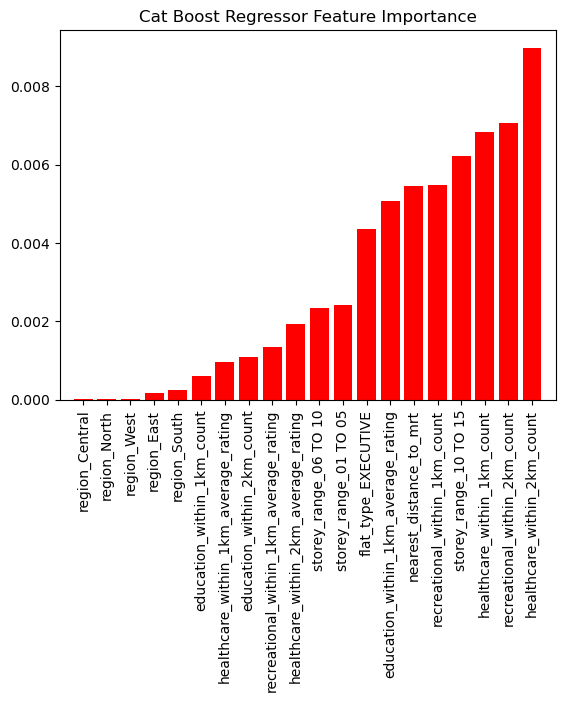

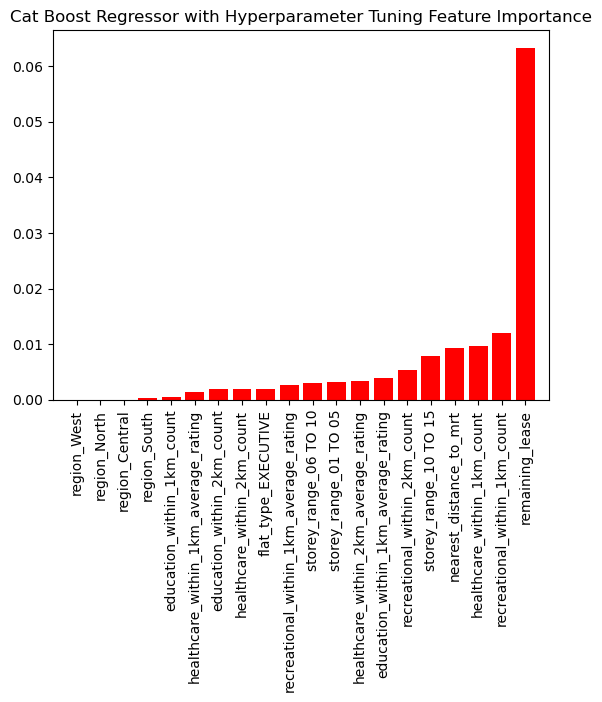

In [ ]:
# Feature Importance Visualisation
skplt.estimators.plot_feature_importances(reg_cbr, feature_names = feature_names,
                                         title="Cat Boost Regressor Feature Importance",
                                         x_tick_rotation=90, order="ascending");
skplt.estimators.plot_feature_importances(gscv_cbr.best_estimator_, feature_names = feature_names,
                                         title="Cat Boost Regressor with Hyperparameter Tuning Feature Importance",
                                         x_tick_rotation=90, order="ascending");

The Cat Boost Regressor Feature Importance plot displays the significance of each attribute in the regression model. A higher bar denotes a greater influence on the model's predictions, with "healthcare_within_2km_count" standing out as the most impactful feature in this particular model. However, after hyperparameter tuning, "remaining_lease" stood out as the most impactful feature in this particular model.

### Conclusion

Based on the model trainings of the 4 advanced models, [Model Name] is the best performing model with the highest coefficient of determination of [value] and the lowest RMSE of [value]. The rankings for the performance of the advanced models are as follows [Model A] > [Model B] > [Model C] > [Model D]. Given [Model Name] is the best performing model, we will be using [Model Name] for the future predictions of HDB Resale Prices in Singapore.

In [ ]:
# Dump Model Into Pickle
pickle.dump(gscv_rfr, open('price_model.pkl', 'wb'))